In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import tensorflow as tf  # pytorch for the model, tensorflow for tokenizer
import gensim
from dataset import Dataset

c:\Users\karab\Desktop\turkish-word-embeddings\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.__version__)
torch.cuda.get_device_name(0)

1.13.1+cu117


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [215]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [216]:
# read train and test csv
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

train_neutraldf = pd.read_csv("train_neutral.csv")
test_neutraldf = pd.read_csv("test_neutral.csv")

# combine dfs
traindf = pd.concat([traindf, train_neutraldf], ignore_index=True)
testdf = pd.concat([testdf, test_neutraldf], ignore_index=True)

traindf['rating'] = traindf['rating'].apply(lambda x: x*2 - 1).astype(int)
testdf['rating'] = testdf['rating'].apply(lambda x: x*2 - 1).astype(int)


10


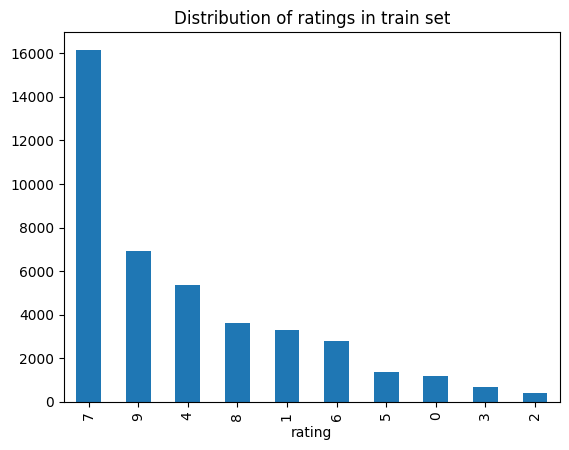

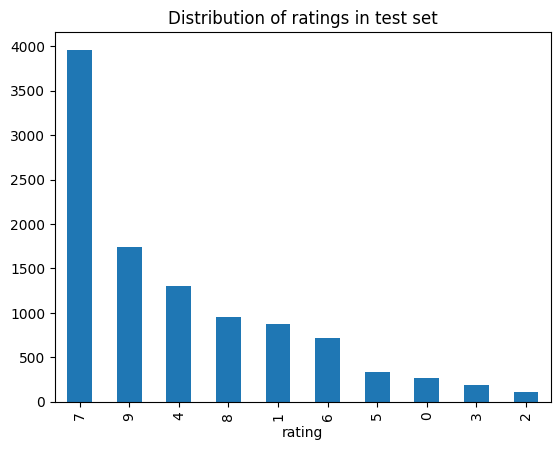

6911

In [227]:
import matplotlib.pyplot as plt
# number of unique ratings
print(traindf['rating'].nunique())
# visualize number of ratings
traindf['rating'].value_counts().plot(kind = 'bar')
plt.title('Distribution of ratings in train set')
plt.show()

# visualize ratings for test
testdf['rating'].value_counts().plot(kind = 'bar')
plt.title('Distribution of ratings in test set')
plt.show()

In [228]:
"""
df_majority = traindf[(traindf['rating']==7)] 
df_minority = traindf[(traindf['rating']!=7)] 

# shuffle select only 1000 rows from df_majority
df_majority = df_majority.sample(frac=1).reset_index(drop=True)
df_majority = df_majority.iloc[:6500, :]
df_majority.shape

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority], ignore_index=True)


df_upsampled['rating'].value_counts().plot(kind = 'bar')
plt.title('Distribution of ratings in train set')
plt.show()

df_majority_test = testdf[(testdf['rating']==7)] 
df_minority_test = testdf[(testdf['rating']!=7)] 

# shuffle select only 1000 rows from df_majority
df_majority_test = df_majority_test.sample(frac=1).reset_index(drop=True)
df_majority_test = df_majority_test.iloc[:1800, :]

# Combine majority class with upsampled minority class
df_upsampled_test = pd.concat([df_majority_test, df_minority_test], ignore_index=True)
df_upsampled_test['rating'].value_counts().plot(kind = 'bar')
plt.title('Distribution of ratings in train set')
plt.show()
traindf = df_upsampled
testdf = df_upsampled_test
"""


In [239]:
# get label
trainy = traindf['rating'].values
testy = testdf['rating'].values

In [240]:
# K-FOLD CROSS VALIDATION SETUP
kf = model_selection.StratifiedKFold(n_splits=5)

# assign folds to [0, 1, 2, 3, 4]
for fold, (train_, valid_) in enumerate(kf.split(X=traindf, y=trainy)):
    traindf.loc[valid_, 'kfold'] = fold

print("Total number of rows: ", traindf.shape[0])
print("Number of rows with kfold = 0", traindf[traindf.kfold==0].shape[0])
print("Number of rows with kfold = 1", traindf[traindf.kfold==1].shape[0])
print("Number of rows with kfold = 2", traindf[traindf.kfold==2].shape[0])
print("Number of rows with kfold = 3", traindf[traindf.kfold==3].shape[0])
print("Number of rows with kfold = 4", traindf[traindf.kfold==4].shape[0])

Total number of rows:  32119
Number of rows with kfold = 0 6424
Number of rows with kfold = 1 6424
Number of rows with kfold = 2 6424
Number of rows with kfold = 3 6424
Number of rows with kfold = 4 6423


In [241]:
MODEL = "C:/Users/karab/Desktop/Models/elmo-Turkish-CoNLL17.wordvectors"
NUM = traindf['rating'].nunique()

In [242]:
#load fasttext embeddings
print('loading word embeddings...')
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
            MODEL,
            binary=True,
            no_header=False
        )

loading word embeddings...


In [243]:
print(len(word_vectors))
word_vectors["bilgisayar"].shape  # 300 dimensions

327299


(1024,)

In [244]:
trainy

array([7, 7, 7, ..., 6, 4, 4])

In [245]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(LSTM, self).__init__()
        # Number of words = number of rows in embedding matrix
        num_words = embedding_matrix.shape[0]
        # Dimension of embedding is num of columns in the matrix
        embedding_dim = embedding_matrix.shape[1]
        # Define an input embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,
                                      embedding_dim=embedding_dim)
        # Embedding matrix actually is collection of parameter
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        # Because we use pretrained embedding (GLove, Fastext,etc) so we turn off requires_grad-meaning we do not train gradient on embedding weight
        self.embedding.weight.requires_grad = False
        # LSTM with hidden_size = 128
        self.lstm = nn.LSTM(
                            embedding_dim, 
                            128,
                            bidirectional=True,
                            batch_first=True,
                             )
        # Input(512) because we use bi-directional LSTM ==> hidden_size*2 + maxpooling **2  = 128*4 = 512, will be explained more on forward method
        self.out = nn.Linear(512, NUM)
    def forward(self, x):
        # pass input (tokens) through embedding layer
        x = self.embedding(x)
        # fit embedding to LSTM
        hidden, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        # concat avg_pool and max_pool (so we have 256 size, also because this is bidirectional ==> 256*2 = 512)
        out = torch.cat((avg_pool, max_pool), 1)
        # fit out to self.out to conduct dimensionality reduction from 512 to 1
        out = self.out(out)
        # return output
        return out

In [246]:
import torch.nn.functional as F
def train(data_loader, model, optimizer, device):
    """
    this is model training for one epoch
    data_loader:  this is torch dataloader, just like dataset but in torch and devide into batches
    model : lstm
    optimizer : torch optimizer : adam
    device:  cuda or cpu
    """
    # set model to training mode
    model.train()
    # go through batches of data in data loader
    for data in data_loader:
        reviews = data['review']
        # binary: data['target']: torch.Size([16])
        # multi: data['target']: torch.Size([16, NUM OF CLASSES])

        # convert data['target'] to one-hot encoded version
        targets = F.one_hot(data['target'], num_classes=NUM)

        # move the data to device that we want to use
        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        
        # clear the gradient
        optimizer.zero_grad()
        # make prediction from model
        predictions = model(reviews)
        # caculate the losses
        loss = nn.BCEWithLogitsLoss()(predictions, targets)
        # backprob
        loss.backward()
        #single optimization step
        optimizer.step()

In [247]:
def evaluate(data_loader, model, device):
    final_predictions = []
    final_targets = []
    model.eval()
    # turn off gradient calculation
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']

            targets = data['target']
            targets = F.one_hot(data['target'], num_classes=NUM)

            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)
            # make prediction
            predictions = model(reviews)
            # move prediction and target to cpu
            predictions = predictions.cpu().numpy().tolist()
            targets = targets.cpu().numpy().tolist()
            # add predictions to final_prediction
            final_predictions.extend(predictions)
            final_targets.extend(targets)
    return final_predictions, final_targets

In [248]:
MAX_LEN = 128 # maximum length for a sentence
DIM = 1024
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5

In [249]:
def create_embedding_matrix(word_index, embedding_dict=None, dim=300):
    """
     this function create the embedding matrix save in numpy array
    :param word_index: a dictionary with word: index_value
    :param embedding_dict: a dict with word embedding
    :d_model: the dimension of word pretrained embedding
    :return a numpy array with embedding vectors for all known words
    """
    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

# embedding_dict['word'] = vector
# word_index['word'] = index
# embedding_matrix[index] = vector

In [250]:
traindf['review'].values.tolist()[:5] # list of sentences

['Başarılı bir devam filmi olmuş. Cola ve cipsle ooooohhh...\n',
 "Zamaninin en cesur filmlerinden biri olan 'taxi driver', bircok unutulmaz planla dolu, tum oyuncu kadrosunun sular seller gibi oynadigi, Scorsese'nin 'raging bull' ve 'goodfellas'tan sonraki en iyi filmi... (9/10)\n",
 'bu filmde bir iki klişe beni rahasız etti ama yine izlenilebilecek tarzda güzel bir film.tavsiye ederim\n',
 'buna benzer bir film bulabilirseniz bir mucize halen izlenebilecek kalite.farklı bir şans olabilir\n',
 'ilk filmi bildiğim için karşılaşacağım şeyi tahmin ederek gittim.yani hazırlıklıydım ve tahminimden de iyi bir dewam filmi olmuş diyebilirim.tabi dustin hoffman barbra streisand ın katılımlarınıda unutmamak lazım.son zamanlarda en çok güldüğüm filmlerden birisiydi.kötü anlamda eleştirecak birşey yok gibi.çok keyifli bir hollywood komedisi. ufaklığın küfürünün ağzıma dolandığınıda söylemeliyim ass holeeeeeeeeeee!! :))\n']

In [251]:
# STEP 1: Tokenization
# use tf.keras for tokenization,  
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(traindf['review'].values.tolist())

In [252]:
print('Load embeddings')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=word_vectors, dim=DIM)


for fold in range(5):
    # STEP 2: cross validation
    train_df = traindf[traindf.kfold != fold].reset_index(drop=True)
    valid_df = traindf[traindf.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = Dataset(reviews=xtrain, targets=train_df['rating'].values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = Dataset(reviews=xtest, targets=valid_df['rating'].values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model = LSTM(embedding_matrix)
    # set model to cuda device
    model.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print('training model')

    for epoch in tqdm(range(EPOCHS)):
        # train one epoch
        train(train_data_loader, model, optimizer, device)
        # validate
        outputs, targets = evaluate(valid_data_loader, model, device)
        outputs = [np.array(out) >= max(out) for out in outputs]
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

Load embeddings
training model


 20%|██        | 1/5 [00:18<01:15, 18.76s/it]

FOLD:0, epoch: 0, accuracy_score: 0.1695205479452055


 40%|████      | 2/5 [00:32<00:47, 15.95s/it]

FOLD:0, epoch: 1, accuracy_score: 0.17014321295143212


 60%|██████    | 3/5 [00:48<00:31, 15.82s/it]

FOLD:0, epoch: 2, accuracy_score: 0.17761519302615192


 80%|████████  | 4/5 [01:03<00:15, 15.62s/it]

FOLD:0, epoch: 3, accuracy_score: 0.1819738480697385


100%|██████████| 5/5 [01:19<00:00, 15.96s/it]

FOLD:0, epoch: 4, accuracy_score: 0.18166251556662516


training model


 20%|██        | 1/5 [00:15<01:03, 15.79s/it]

FOLD:1, epoch: 0, accuracy_score: 0.16843088418430885


 40%|████      | 2/5 [00:34<00:51, 17.30s/it]

FOLD:1, epoch: 1, accuracy_score: 0.1690535491905355


 60%|██████    | 3/5 [00:49<00:32, 16.39s/it]

FOLD:1, epoch: 2, accuracy_score: 0.16936488169364883


 80%|████████  | 4/5 [01:05<00:16, 16.29s/it]

FOLD:1, epoch: 3, accuracy_score: 0.16936488169364883


100%|██████████| 5/5 [01:23<00:00, 16.62s/it]

FOLD:1, epoch: 4, accuracy_score: 0.16920921544209216


training model


 20%|██        | 1/5 [00:17<01:08, 17.25s/it]

FOLD:2, epoch: 0, accuracy_score: 0.16796388542963886


 40%|████      | 2/5 [00:36<00:55, 18.39s/it]

FOLD:2, epoch: 1, accuracy_score: 0.16874221668742218


 60%|██████    | 3/5 [00:54<00:36, 18.04s/it]

FOLD:2, epoch: 2, accuracy_score: 0.16827521793275219


 80%|████████  | 4/5 [01:11<00:17, 17.83s/it]

FOLD:2, epoch: 3, accuracy_score: 0.16765255292652553


100%|██████████| 5/5 [01:26<00:00, 17.38s/it]

FOLD:2, epoch: 4, accuracy_score: 0.1660958904109589


training model


 20%|██        | 1/5 [00:16<01:07, 16.95s/it]

FOLD:3, epoch: 0, accuracy_score: 0.1665628891656289


 40%|████      | 2/5 [00:32<00:47, 15.98s/it]

FOLD:3, epoch: 1, accuracy_score: 0.16936488169364883


 60%|██████    | 3/5 [00:47<00:31, 15.58s/it]

FOLD:3, epoch: 2, accuracy_score: 0.17263387297633873


 80%|████████  | 4/5 [01:02<00:15, 15.47s/it]

FOLD:3, epoch: 3, accuracy_score: 0.17543586550435866


100%|██████████| 5/5 [01:17<00:00, 15.48s/it]

FOLD:3, epoch: 4, accuracy_score: 0.175747198007472


training model


 20%|██        | 1/5 [00:14<00:56, 14.23s/it]

FOLD:4, epoch: 0, accuracy_score: 0.16658882142301104


 40%|████      | 2/5 [00:30<00:46, 15.40s/it]

FOLD:4, epoch: 1, accuracy_score: 0.16970263116923556


 60%|██████    | 3/5 [00:47<00:31, 15.98s/it]

FOLD:4, epoch: 2, accuracy_score: 0.17328351237739373


 80%|████████  | 4/5 [01:02<00:15, 15.56s/it]

FOLD:4, epoch: 3, accuracy_score: 0.17452903627588354


100%|██████████| 5/5 [01:16<00:00, 15.39s/it]

FOLD:4, epoch: 4, accuracy_score: 0.17312782189008252


In [258]:
# test on test set testdf and testy
xtest = tokenizer.texts_to_sequences(testdf.review.values)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
test_dataset = Dataset(reviews=xtest, targets=testy)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
outputs, targets = evaluate(test_data_loader, model, device)
outputs = [np.array(out) >= max(out) for out in outputs]
accuracy = metrics.accuracy_score(targets, outputs)
print(f'accuracy_score: {accuracy}')

accuracy_score: 0.16500180527139247


In [254]:
targets = [[0, 0, 1, 0, 0],[0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0]]
outputs = [[0.5, 0, 11.5, 6, 0],[8, 9, 0, 16, 0], [1, 4.5, 2, 3, 0], [0, 7, 6, 5, 0]]
outputs = [np.array(out) >= max(out) for out in outputs]
metrics.accuracy_score(targets, outputs)

0.75

In [259]:
from torchmetrics.classification import MulticlassF1Score
metric = MulticlassF1Score(num_classes=NUM)
metric(torch.tensor(targets), torch.tensor(outputs))

C:\Users\karab\AppData\Local\Temp\ipykernel_15756\3408045748.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  metric(torch.tensor(targets), torch.tensor(outputs))


tensor(0.1072)

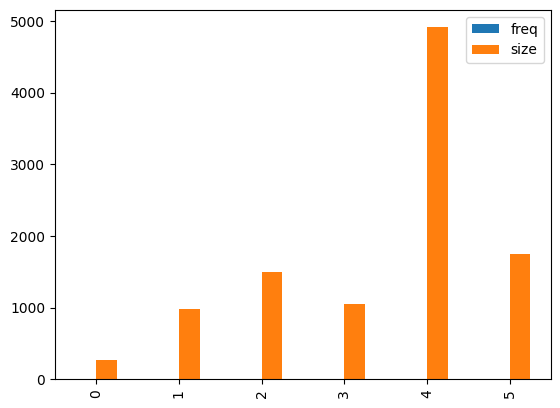

In [209]:
# one-hot encoding to indices
targetsx = [np.argmax(target) for target in targets]
# plot targets
df = pd.DataFrame({'freq': targetsx})
df['freq'] =  df['freq'].apply(lambda x: (x+1)/2).astype(int) 
df.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()